In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TrainingArguments, Trainer
import torch
from torch import nn
from transformers import AutoModel, AutoConfig
from sklearn.preprocessing import MinMaxScaler

2024-07-17 07:43:11.027883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 07:43:11.027943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 07:43:11.031557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 07:43:11.043583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 07:43:12.329818: W tensorflow/compiler/tf2

In [4]:
# Define the model
class BertForMultivariateRegression(nn.Module):
    def __init__(self, model_name_or_path, num_labels=5):
        super(BertForMultivariateRegression, self).__init__()
        self.num_labels = num_labels
        self.config = AutoConfig.from_pretrained(model_name_or_path)
        self.bert = AutoModel.from_pretrained(model_name_or_path, config=self.config)
        self.regression = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels),
            #nn.ReLU(),
            #nn.Dropout(0.1),
            #nn.Linear(128, ),
        )
        self.init_weights()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def init_weights(self):
        for module in self.regression:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output
        logits = self.regression(pooler_output)

        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits, labels)

        return (loss, logits) if loss is not None else logits

    def save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)
        self.config.save_pretrained(save_directory)
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def from_pretrained(cls, save_directory, model_name_or_path, num_labels=5):
        config = AutoConfig.from_pretrained(save_directory)
        model = cls(model_name_or_path, num_labels=num_labels)
        state_dict = torch.load(os.path.join(save_directory, "pytorch_model.bin"), map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        return model

In [15]:
# Load the CSV file
data = pd.read_csv("cleaned_filtered_data.csv", sep=None, engine='python')
 # find in /data/First_datasetFor_Regression_model/annotation_space_data.csv
# Prepare the data
sentences = data['text'].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data[['1', '2', '3', '4', '5']] = scaler.fit_transform(data[['1', '2', '3', '4', '5']])
labels = data[['1', '2', '3', '4', '5']].values

train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2)

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

train_encodings = tokenizer(train_sentences.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_sentences.tolist(), truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [12]:
# scaler values

scales = {'min_vals': [0.9014031435288774,
  -0.20944372492040664,
  0.3389173248677211,
  0.5175195569772773,
  0.9111702659370386],
 'scale': [0.09026005554938518,
  0.11147839708128467,
  0.05688428995404781,
  0.0417984150486127,
  0.014517997301216296],
 'data_min': [-21.0658317453454,
  -7.0915647854459,
  -23.5375588927861,
  -36.3056722416953,
  -131.641453451498],
 'data_max': [1.09236423433371,
  10.8491309220973,
  11.6215333911404,
  11.5430320135724,
  6.11859419863091]}

In [16]:
min_vals = scaler.min_
scale = scaler.scale_
data_min = scaler.data_min_
data_max = scaler.data_max_

# Print or store these values
print("Minimum values:", min_vals)
print("Scale:", scale)
print("Data minimum:", data_min)
print("Data maximum:", data_max)

# Optionally, save these parameters for later use
import json

scaling_params = {
    "min_vals": min_vals.tolist(),
    "scale": scale.tolist(),
    "data_min": data_min.tolist(),
    "data_max": data_max.tolist()
}

with open("scaling_params.json", "w") as f:
    json.dump(scaling_params, f)

Minimum values: [ 0.90140314 -0.20944372  0.33891732  0.51751956  0.91117027]
Scale: [0.09026006 0.1114784  0.05688429 0.04179842 0.014518  ]
Data minimum: [ -21.06583175   -7.09156479  -23.53755889  -36.30567224 -131.64145345]
Data maximum: [ 1.09236423 10.84913092 11.62153339 11.54303201  6.1185942 ]


In [7]:
# Tokenize the sentences without truncation to find those exceeding the maximum length
tokenized_lengths = data['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# Find sentences exceeding 512 tokens
exceeding_sentences = data[tokenized_lengths > 512]

# Display the sentences exceeding 512 tokens and their lengths
exceeding_sentences_with_lengths = exceeding_sentences[['text']].assign(token_length=tokenized_lengths[tokenized_lengths > 512])
print(exceeding_sentences_with_lengths)

#filtered_data = data[tokenized_lengths <= 512]

#filtered_csv_file_path = "cleaned_filtered_data.csv"  # Update with actual CSV file path
#filtered_data.to_csv(filtered_csv_file_path, index=False)

Empty DataFrame
Columns: [text, token_length]
Index: []


In [8]:
# Create datasets
class GreekSentencesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
train_dataset = GreekSentencesDataset(train_encodings, train_labels)
val_dataset = GreekSentencesDataset(val_encodings, val_labels)

In [10]:
# Initialize the model
model_name_or_path = "nlpaueb/bert-base-greek-uncased-v1"
num_labels = 5
model = BertForMultivariateRegression(model_name_or_path, num_labels)

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

In [11]:
from transformers import AdamW

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=10,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    warmup_steps=10,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
    report_to="none",
    evaluation_strategy="epoch",
    logging_strategy="epoch"
)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, None)
)

In [12]:
# Train and evaluate the model
trainer.train()
trainer.evaluate()

# Save the model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Available keys in logs:
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', '

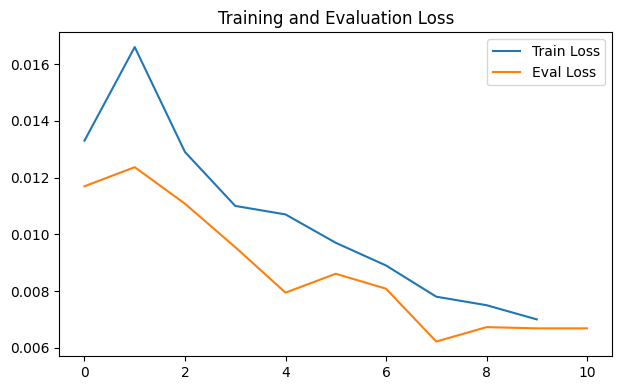

In [68]:
logs = trainer.state.log_history

# Print all keys in the logs to see what's available
print("Available keys in logs:")
for log in logs:
    print(log.keys())

# Extract available metrics
train_losses = [log['loss'] for log in logs if 'loss' in log]
eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]
r2_scores = [log['eval_r2_score_mean'] for log in logs if 'eval_r2_score_mean' in log]

# Plot available metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
if eval_losses:
    plt.plot(eval_losses, label='Eval Loss')
plt.legend()
plt.title('Training Loss' if not eval_losses else 'Training and Evaluation Loss')

if r2_scores:
    plt.subplot(1, 2, 2)
    plt.plot(r2_scores, label='Mean R-squared')
    plt.legend()
    plt.title('Mean R-squared Score')

plt.tight_layout()
plt.show()